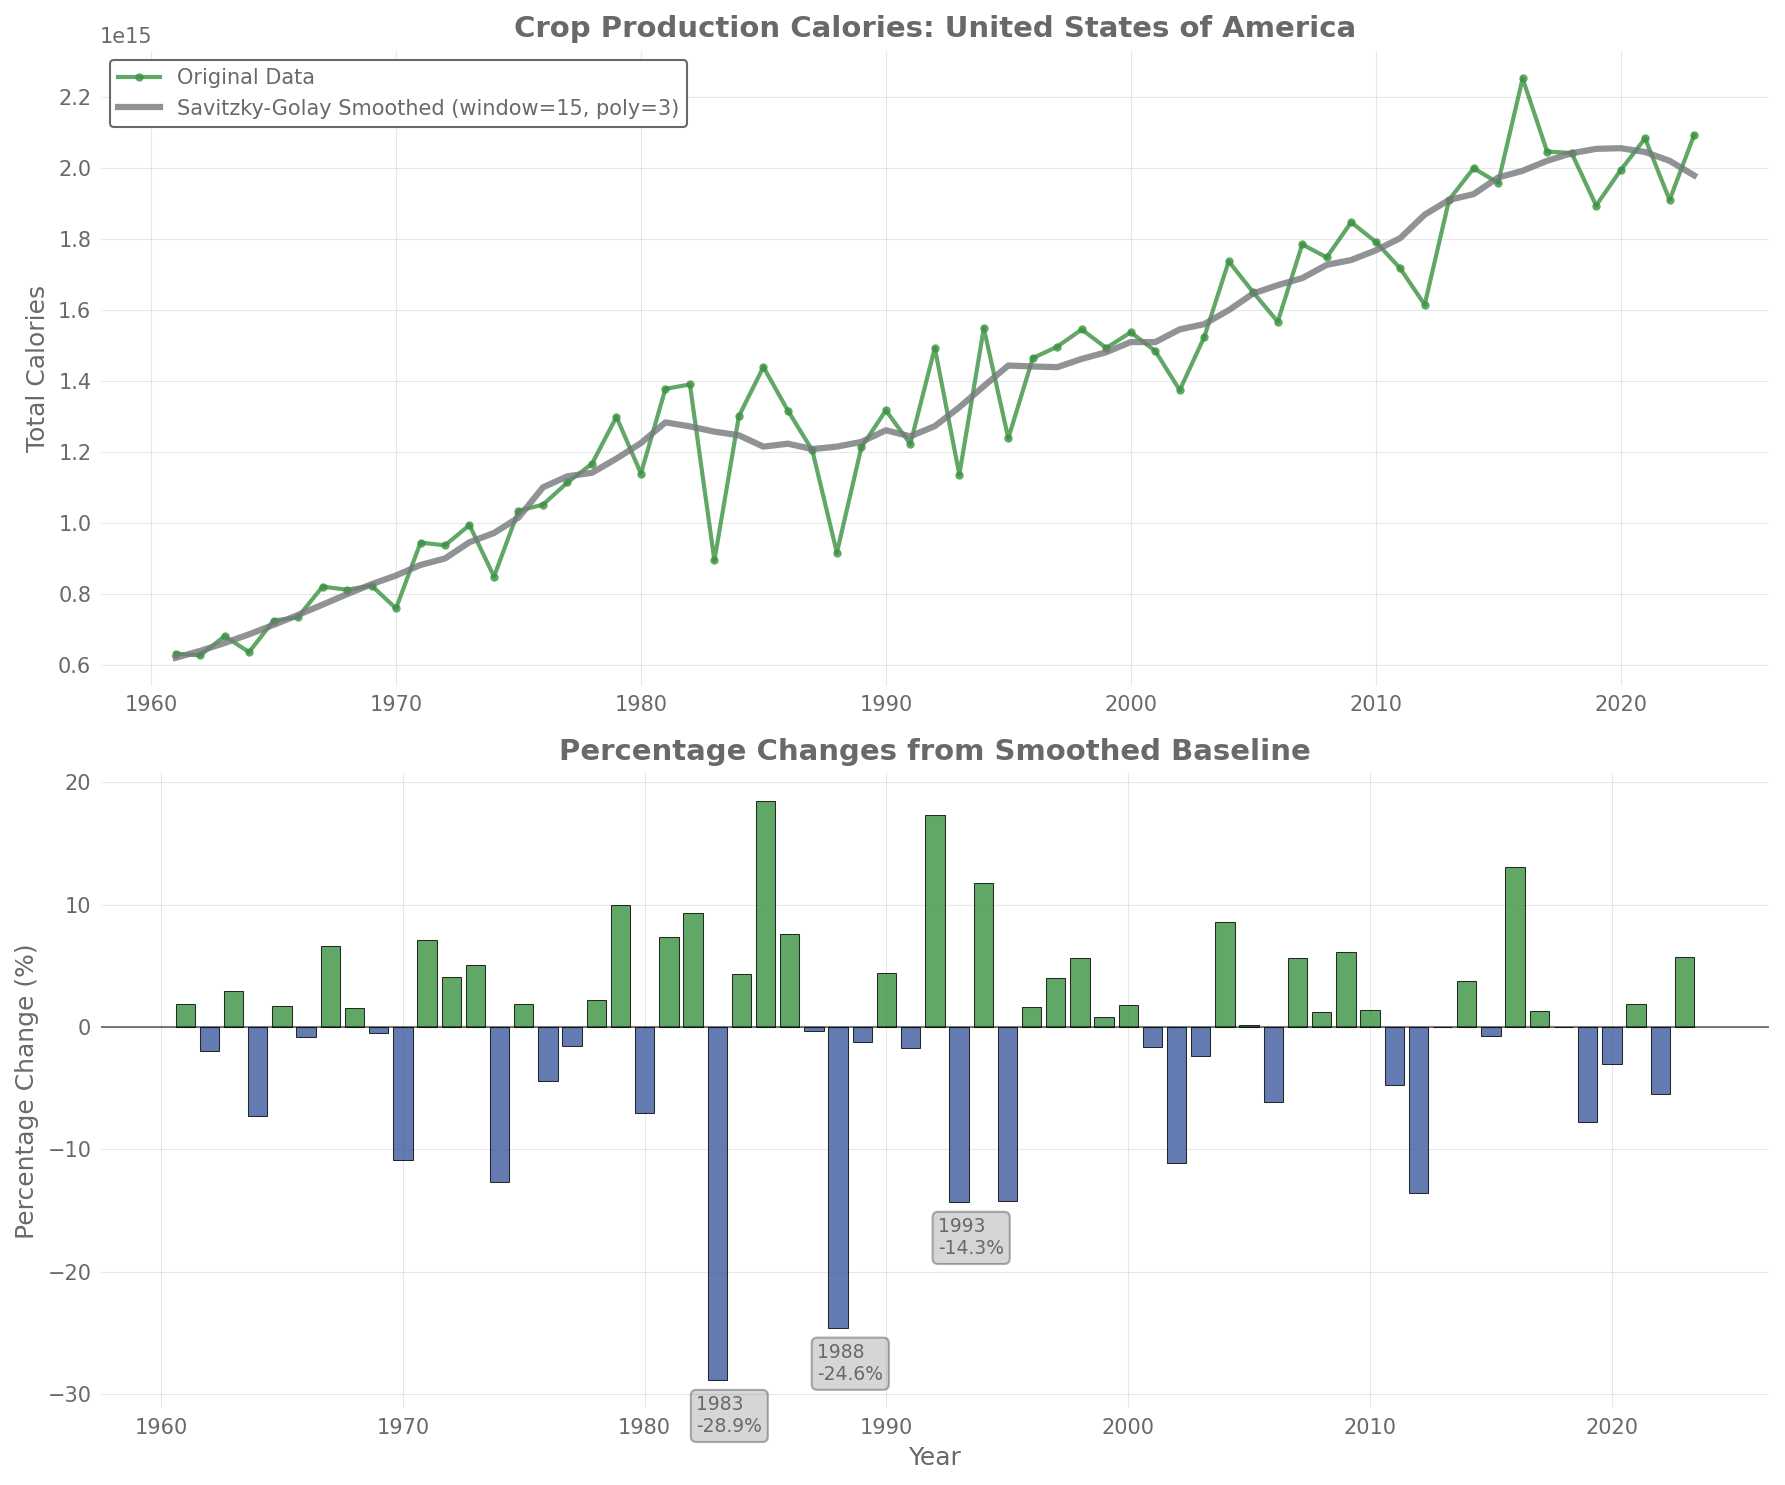


Summary for United States of America:
Data range: 1961 - 2023
Number of years with data: 63
Savitzky-Golay parameters: window_length=15, polyorder=3

Shock Analysis:
Years with shocks ≤ -5%: 13
Years with shocks ≤ -10%: 8
Largest negative shock: -28.88% in 1983
Largest positive deviation: 18.46% in 1985

Top 3 biggest negative shocks (labeled on plot):
  1983: -28.88%
  1988: -24.61%
  1993: -14.33%


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from scipy.signal import savgol_filter

# Add src directory to path to import our functions
sys.path.append('../src')
from calculate_food_shocks import calculate_changes_savgol

# Set ALLFED plotting style
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

# Load the calories data
calories_df = pd.read_csv('../results/calories_by_countries.csv', index_col=0)

# Configuration parameters
selected_country = "United States of America"  # Options: any country from calories_df.index
window_length = 15 # Must be odd number
polyorder = 3      # Must be less than window_length
num_shocks_to_label = 3  # Number of biggest negative shocks to label

# Extract data for selected country
country_data = calories_df.loc[selected_country]
years = [int(col) for col in country_data.index]
values = country_data.values

# Remove NaN values for processing
valid_mask = ~np.isnan(values)
years_clean = np.array(years)[valid_mask]
values_clean = values[valid_mask]

# Apply Savitzky-Golay filter to create smoothed baseline
smoothed_values = savgol_filter(values_clean, window_length, polyorder)

# Calculate percentage changes
pct_changes = ((values_clean - smoothed_values) / smoothed_values) * 100

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original data vs smoothed baseline
ax1.plot(years_clean, values_clean, 'o-', alpha=0.8, linewidth=2, 
        label='Original Data', markersize=4, color="#3A913F")
ax1.plot(years_clean, smoothed_values, '-', linewidth=3, alpha=0.8,
        label=f'Savitzky-Golay Smoothed (window={window_length}, poly={polyorder})', color="#75787B")
ax1.set_title(f'Crop Production Calories: {selected_country}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Calories', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Format y-axis to show values in scientific notation
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Bottom plot: Percentage changes (shocks)
colors = ['#3D5A9E' if x < 0 else '#3A913F' for x in pct_changes]
bars = ax2.bar(years_clean, pct_changes, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add horizontal lines for reference
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

ax2.set_title('Percentage Changes from Smoothed Baseline', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Find and label only the x biggest negative shocks
negative_shocks = pct_changes < 0
if np.any(negative_shocks) and num_shocks_to_label > 0:
    # Get indices of negative shocks, sorted by magnitude (most negative first)
    negative_indices = np.where(negative_shocks)[0]
    negative_values = pct_changes[negative_indices]
    sorted_indices = negative_indices[np.argsort(negative_values)]
    
    # Select top x biggest shocks (limit by available data)
    top_shock_indices = sorted_indices[:min(num_shocks_to_label, len(sorted_indices))]
    
    # Label the selected shocks
    for idx in top_shock_indices:
        year = years_clean[idx]
        value = pct_changes[idx]
        ax2.annotate(f'{year}\n{value:.1f}%', 
                    xy=(year, value), xytext=(-10, -25),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='#75787B', alpha=0.3))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for {selected_country}:")
print(f"Data range: {years_clean[0]} - {years_clean[-1]}")
print(f"Number of years with data: {len(years_clean)}")
print(f"Savitzky-Golay parameters: window_length={window_length}, polyorder={polyorder}")
print(f"\nShock Analysis:")
print(f"Years with shocks ≤ -5%: {np.sum(pct_changes <= -5)}")
print(f"Years with shocks ≤ -10%: {np.sum(pct_changes <= -10)}")
print(f"Largest negative shock: {np.min(pct_changes):.2f}% in {years_clean[np.argmin(pct_changes)]}")
print(f"Largest positive deviation: {np.max(pct_changes):.2f}% in {years_clean[np.argmax(pct_changes)]}")

# Show the top x biggest negative shocks
negative_shocks_exist = np.any(pct_changes < 0)
if negative_shocks_exist and num_shocks_to_label > 0:
    # Get all negative shocks sorted by magnitude
    negative_indices = np.where(pct_changes < 0)[0]
    negative_years = years_clean[negative_indices]
    negative_values = pct_changes[negative_indices]
    
    # Sort by shock magnitude (most negative first)
    sorted_order = np.argsort(negative_values)
    top_indices = sorted_order[:min(num_shocks_to_label, len(sorted_order))]
    
    print(f"\nTop {min(num_shocks_to_label, len(top_indices))} biggest negative shocks (labeled on plot):")
    for i in top_indices:
        year = negative_years[i]
        value = negative_values[i]
        print(f"  {year}: {value:.2f}%")
else:
    print(f"\nNo negative shocks found for {selected_country}")

/tmp/ipykernel_27052/347251789.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='best')
/tmp/ipykernel_27052/347251789.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='best')


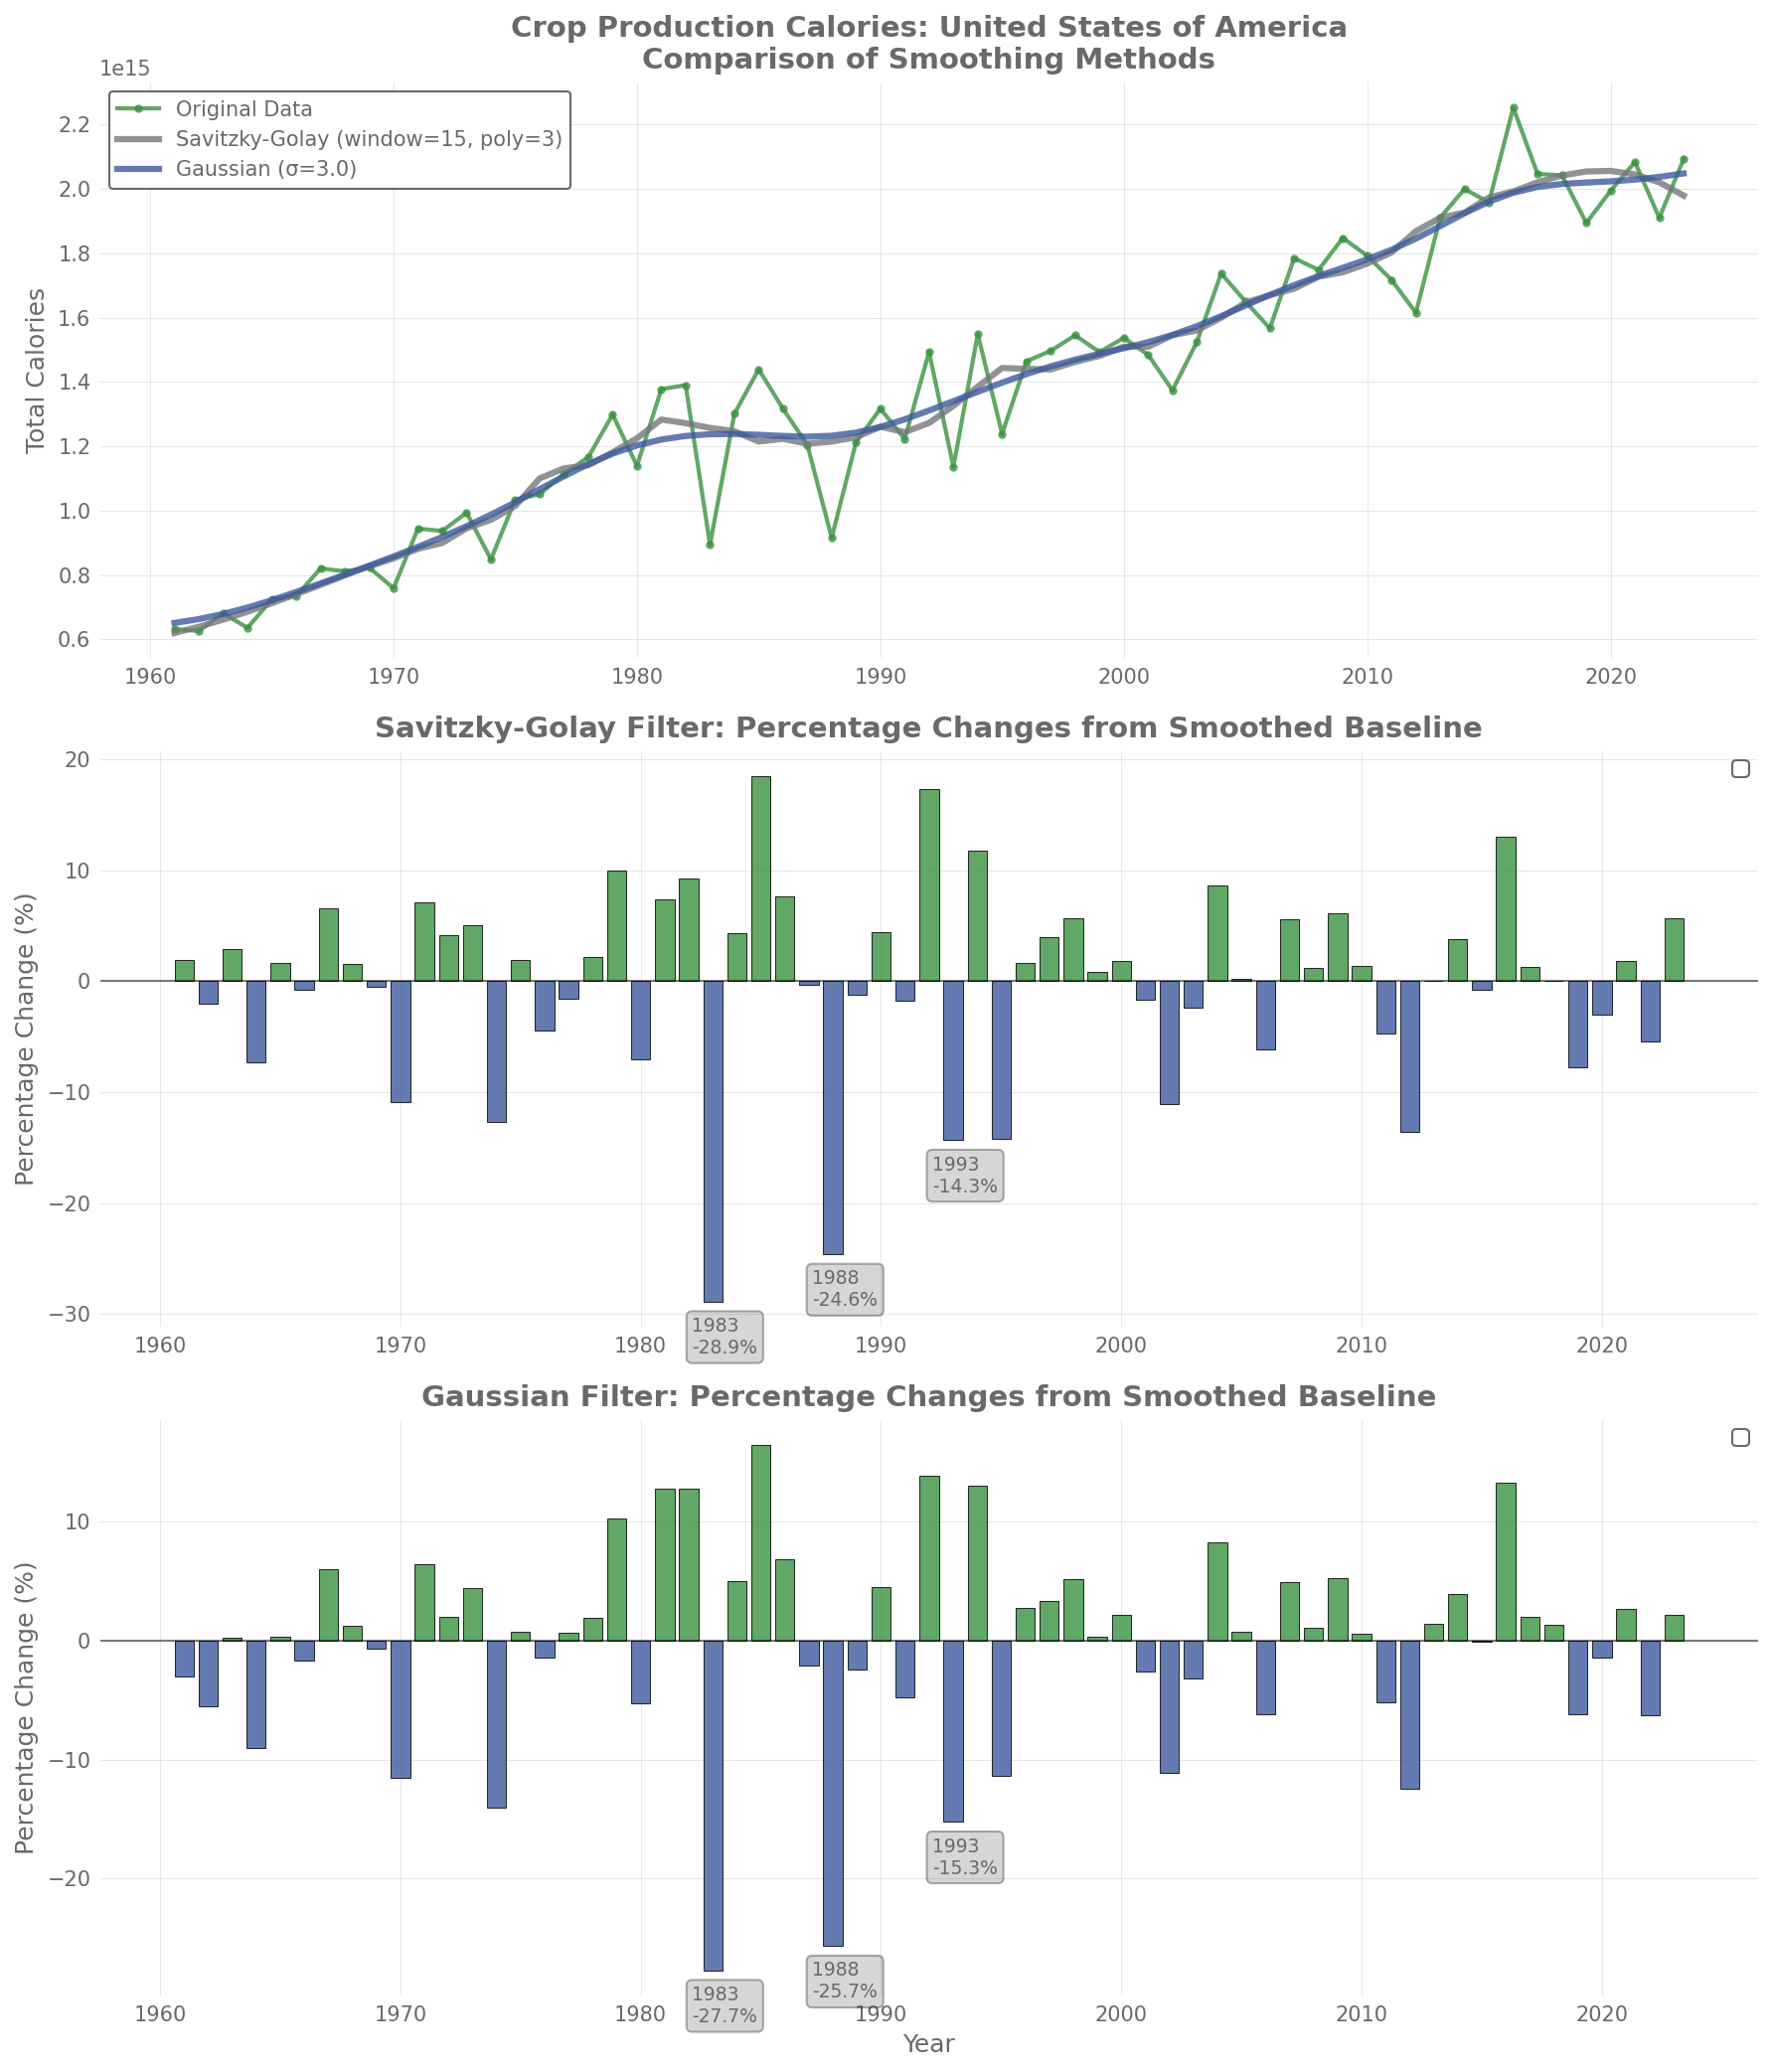

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# Add src directory to path to import our functions
sys.path.append('../src')
from calculate_food_shocks import calculate_changes_savgol, calculate_changes_gaussian

# Set ALLFED plotting style
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

# Load the calories data
calories_df = pd.read_csv('../results/calories_by_countries.csv', index_col=0)

# Configuration parameters
selected_country = "United States of America"  # Options: any country from calories_df.index
# Savitzky-Golay parameters
window_length = 15  # Must be odd number
polyorder = 3      # Must be less than window_length
# Gaussian filter parameter
sigma = 3.0        # Standard deviation in years
num_shocks_to_label = 3  # Number of biggest negative shocks to label

# Extract data for selected country
country_data = calories_df.loc[selected_country]
years = [int(col) for col in country_data.index]
values = country_data.values

# Remove NaN values for processing
valid_mask = ~np.isnan(values)
years_clean = np.array(years)[valid_mask]
values_clean = values[valid_mask]

# Apply Savitzky-Golay filter to create smoothed baseline
smoothed_savgol = savgol_filter(values_clean, window_length, polyorder)
pct_changes_savgol = ((values_clean - smoothed_savgol) / smoothed_savgol) * 100

# Apply Gaussian filter to create smoothed baseline
smoothed_gaussian = gaussian_filter1d(values_clean, sigma=sigma, mode='nearest')
pct_changes_gaussian = ((values_clean - smoothed_gaussian) / smoothed_gaussian) * 100

# Create the visualization with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Top plot: Original data vs both smoothed baselines
ax1.plot(years_clean, values_clean, 'o-', alpha=0.8, linewidth=2, 
        label='Original Data', markersize=4, color="#3A913F")
ax1.plot(years_clean, smoothed_savgol, '-', linewidth=3, alpha=0.8,
        label=f'Savitzky-Golay (window={window_length}, poly={polyorder})', 
        color="#75787B")
ax1.plot(years_clean, smoothed_gaussian, '-', linewidth=3, alpha=0.8,
        label=f'Gaussian (σ={sigma})', 
        color="#3D5A9E")
ax1.set_title(f'Crop Production Calories: {selected_country}\nComparison of Smoothing Methods', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Calories', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Middle plot: Savitzky-Golay percentage changes (shocks)
colors_savgol = ['#3D5A9E' if x < 0 else '#3A913F' for x in pct_changes_savgol]
bars_savgol = ax2.bar(years_clean, pct_changes_savgol, color=colors_savgol, 
                      alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax2.set_title('Savitzky-Golay Filter: Percentage Changes from Smoothed Baseline', 
             fontsize=14, fontweight='bold')
ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Label biggest negative shocks for Savgol
negative_shocks_savgol = pct_changes_savgol < 0
if np.any(negative_shocks_savgol) and num_shocks_to_label > 0:
    negative_indices = np.where(negative_shocks_savgol)[0]
    negative_values = pct_changes_savgol[negative_indices]
    sorted_indices = negative_indices[np.argsort(negative_values)]
    top_shock_indices = sorted_indices[:min(num_shocks_to_label, len(sorted_indices))]
    
    for idx in top_shock_indices:
        year = years_clean[idx]
        value = pct_changes_savgol[idx]
        ax2.annotate(f'{year}\n{value:.1f}%', 
                    xy=(year, value), xytext=(-10, -25),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='#75787B', alpha=0.3))

# Bottom plot: Gaussian percentage changes (shocks)
colors_gaussian = ['#3D5A9E' if x < 0 else '#3A913F' for x in pct_changes_gaussian]
bars_gaussian = ax3.bar(years_clean, pct_changes_gaussian, color=colors_gaussian, 
                       alpha=0.8, edgecolor='black', linewidth=0.5)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax3.set_title('Gaussian Filter: Percentage Changes from Smoothed Baseline', 
             fontsize=14, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Percentage Change (%)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# Label biggest negative shocks for Gaussian
negative_shocks_gaussian = pct_changes_gaussian < 0
if np.any(negative_shocks_gaussian) and num_shocks_to_label > 0:
    negative_indices = np.where(negative_shocks_gaussian)[0]
    negative_values = pct_changes_gaussian[negative_indices]
    sorted_indices = negative_indices[np.argsort(negative_values)]
    top_shock_indices = sorted_indices[:min(num_shocks_to_label, len(sorted_indices))]
    
    for idx in top_shock_indices:
        year = years_clean[idx]
        value = pct_changes_gaussian[idx]
        ax3.annotate(f'{year}\n{value:.1f}%', 
                    xy=(year, value), xytext=(-10, -25),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='#75787B', alpha=0.3))

plt.tight_layout()
plt.show()

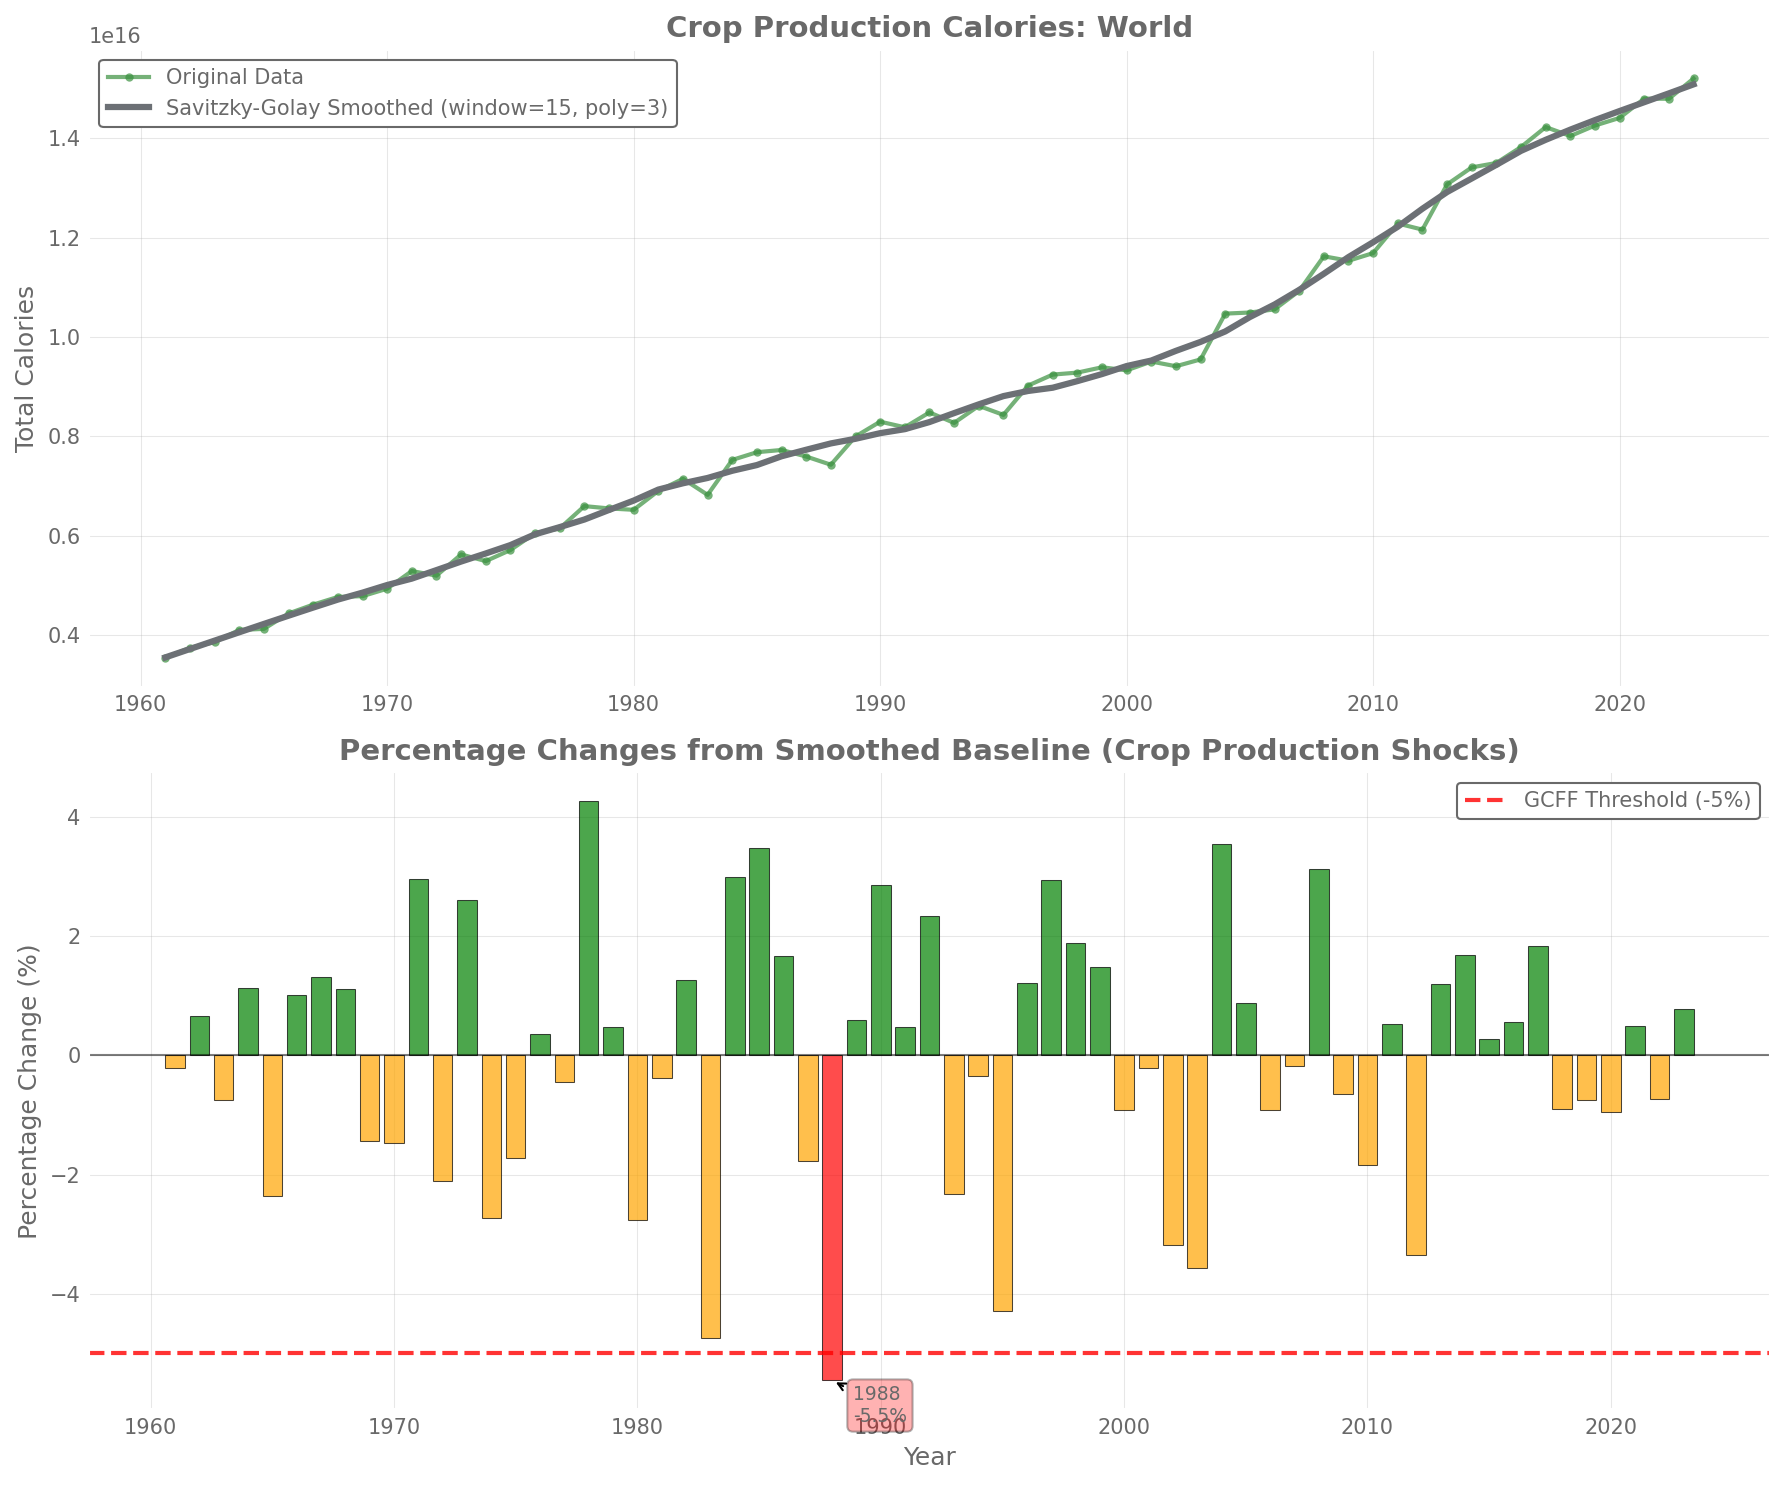


Summary for World:
Data range: 1961 - 2023
Number of years with data: 63
Savitzky-Golay parameters: window_length=15, polyorder=3

Shock Analysis:
Years with shocks ≤ -5%: 1
Years with shocks ≤ -10%: 0
Largest negative shock: -5.45% in 1988
Largest positive deviation: 4.27% in 1978

Years with GCFF-level shocks (≤ -5%):
  1988: -5.45%


In [18]:
# Add src directory to path to import our functions
sys.path.append('../src')
from calculate_food_shocks import calculate_changes_savgol

# Set ALLFED plotting style
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

# Load the calories data
calories_df = pd.read_csv('../results/calories_by_regions.csv', index_col=0)

# Select country to visualize (change this to explore different countries)
selected_country = "World"  # Options: any country from calories_df.index
window_length = 15  # Must be odd number
polyorder = 3      # Must be less than window_length

# Extract data for selected country
country_data = calories_df.loc[selected_country]
years = [int(col) for col in country_data.index]
values = country_data.values

# Remove NaN values for processing
valid_mask = ~np.isnan(values)
years_clean = np.array(years)[valid_mask]
values_clean = values[valid_mask]

# Apply Savitzky-Golay filter to create smoothed baseline
smoothed_values = savgol_filter(values_clean, window_length, polyorder)

# Calculate percentage changes
pct_changes = ((values_clean - smoothed_values) / smoothed_values) * 100

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original data vs smoothed baseline
ax1.plot(years_clean, values_clean, 'o-', alpha=0.7, linewidth=2, 
        label='Original Data', markersize=4)
ax1.plot(years_clean, smoothed_values, '-', linewidth=3, 
        label=f'Savitzky-Golay Smoothed (window={window_length}, poly={polyorder})')
ax1.set_title(f'Crop Production Calories: {selected_country}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Calories', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Format y-axis to show values in scientific notation
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Bottom plot: Percentage changes (shocks)
colors = ['red' if x < -5 else 'orange' if x < 0 else 'green' for x in pct_changes]
bars = ax2.bar(years_clean, pct_changes, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Add horizontal lines for shock thresholds
ax2.axhline(y=-5, color='red', linestyle='--', alpha=0.8, linewidth=2, label='GCFF Threshold (-5%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

ax2.set_title('Percentage Changes from Smoothed Baseline (Crop Production Shocks)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Highlight significant negative shocks
significant_shocks = pct_changes < -5
if np.any(significant_shocks):
   shock_years = years_clean[significant_shocks]
   shock_values = pct_changes[significant_shocks]
   for year, value in zip(shock_years, shock_values):
       ax2.annotate(f'{year}\n{value:.1f}%', 
                   xy=(year, value), xytext=(10, -20),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for {selected_country}:")
print(f"Data range: {years_clean[0]} - {years_clean[-1]}")
print(f"Number of years with data: {len(years_clean)}")
print(f"Savitzky-Golay parameters: window_length={window_length}, polyorder={polyorder}")
print(f"\nShock Analysis:")
print(f"Years with shocks ≤ -5%: {np.sum(pct_changes <= -5)}")
print(f"Years with shocks ≤ -10%: {np.sum(pct_changes <= -10)}")
print(f"Largest negative shock: {np.min(pct_changes):.2f}% in {years_clean[np.argmin(pct_changes)]}")
print(f"Largest positive deviation: {np.max(pct_changes):.2f}% in {years_clean[np.argmax(pct_changes)]}")

# Show the most significant shock years
if np.any(significant_shocks):
   print(f"\nYears with GCFF-level shocks (≤ -5%):")
   shock_years = years_clean[significant_shocks]
   shock_values = pct_changes[significant_shocks]
   for year, value in zip(shock_years, shock_values):
       print(f"  {year}: {value:.2f}%")
else:
   print(f"\nNo GCFF-level shocks (≤ -5%) detected for {selected_country}")